In [1]:
!pip install yahoofinancials
import yahoofinancials

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from datetime import date
from datetime import timedelta

from yahoofinancials import YahooFinancials

from scipy.stats import norm

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation

import warnings
warnings.filterwarnings('ignore')

  Created wheel for yahoofinancials: filename=yahoofinancials-1.6-py3-none-any.whl size=15190 sha256=67eda6f26195ee889b6f809f2c78ca5f63405bbef60428b84d74ead97a9dad54
  Stored in directory: /root/.cache/pip/wheels/4b/63/46/e7110bfee88685fe69e338d1b14d1748921862aa57b6705b60
Successfully built yahoofinancials


In [2]:
end = '2021-08-03'
start = '2016-07-20'
stock_symbol = 'TCS.NS'
yf = YahooFinancials(stock_symbol)

In [4]:
data = yf.get_historical_price_data(start, end, 'monthly')
TCS = pd.DataFrame(data['TCS.NS']['prices'])

df = TCS.dropna()
df

,date,high,low,open,close,volume,adjclose,formatted_date
0,1469989800,1372.400024,1233.375000,1316.000000,1255.650024,46041780,1139.385742,2016-07-31
1,1472668200,1267.474976,1142.375000,1262.449951,1215.400024,51842742,1102.862549,2016-08-31
2,1475260200,1228.824951,1145.500000,1225.000000,1199.349976,41500766,1088.298828,2016-09-30
3,1477938600,1199.849976,1025.949951,1199.849976,1138.025024,54418020,1035.423462,2016-10-31
4,1480530600,1189.300049,1072.824951,1138.500000,1182.775024,41661230,1076.138672,2016-11-30
...,...,...,...,...,...,...,...,...
56,1617215400,3354.350098,3020.000000,3191.100098,3035.649902,61328558,3014.295166,2021-03-31
57,1619807400,3217.750000,3004.000000,3024.899902,3159.149902,43538924,3136.926025,2021-04-30
58,1622485800,3399.649902,3115.000000,3168.600098,3345.750000,45079239,3338.464355,2021-05-31
59,1625077800,3374.000000,3132.399902,3358.000000,3167.449951,44349890,3160.552490,2021-06-30


In [5]:
df = df[["formatted_date", "close"]]
df.rename(columns={"formatted_date": "ds", "close": "y"}, inplace=True)
df

,ds,y
0,2016-07-31,1255.650024
1,2016-08-31,1215.400024
2,2016-09-30,1199.349976
3,2016-10-31,1138.025024
4,2016-11-30,1182.775024
...,...,...
56,2021-03-31,3035.649902
57,2021-04-30,3159.149902
58,2021-05-31,3345.750000
59,2021-06-30,3167.449951


In [6]:
df['ds'] = pd.to_datetime(df['ds'], errors='coerce')

Train Test split

In [7]:
cut_date = '2021-03-19'
mask1 = (df['ds'] <= cut_date)
mask2 = (df['ds'] > cut_date)

X_tr = df.loc[mask1]
X_tst = df.loc[mask2]
print("train shape",X_tr.shape)
print("test shape",X_tst.shape)

train shape (56, 2)
test shape (5, 2)


In [10]:
X_tst

,ds,y
56,2021-03-31,3035.649902
57,2021-04-30,3159.149902
58,2021-05-31,3345.750000
59,2021-06-30,3167.449951
60,2021-07-31,3553.050049


Install library

In [11]:
!pip install fbprophet
from fbprophet import Prophet


Model Building

In [39]:
import tensorflow as tf
tf.random.set_seed(seed=1)
m =Prophet(changepoint_prior_scale=0.1, seasonality_prior_scale=0.01, seasonality_mode='additive',changepoint_range= 0.8) 
m.fit(X_tr)

In [40]:
future = m.make_future_dataframe(periods=5, freq='M')
forecast = m.predict(future)

In [31]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-07-31,1100.802905,1006.821251,1279.802525,1100.802905,1100.802905,40.038119,40.038119,40.038119,40.038119,40.038119,40.038119,0.0,0.0,0.0,1140.841025
1,2016-08-31,1117.746695,1009.643345,1291.413134,1117.746695,1117.746695,30.397131,30.397131,30.397131,30.397131,30.397131,30.397131,0.0,0.0,0.0,1148.143825
2,2016-09-30,1134.143910,1027.101278,1309.115126,1134.143910,1134.143910,32.872216,32.872216,32.872216,32.872216,32.872216,32.872216,0.0,0.0,0.0,1167.016126
3,2016-10-31,1151.087700,985.408913,1255.159667,1151.087700,1151.087700,-32.022472,-32.022472,-32.022472,-32.022472,-32.022472,-32.022472,0.0,0.0,0.0,1119.065228
4,2016-11-30,1167.484915,1016.623515,1298.329468,1167.484915,1167.484915,-8.792054,-8.792054,-8.792054,-8.792054,-8.792054,-8.792054,0.0,0.0,0.0,1158.692861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,2021-03-31,3115.653024,2996.146536,3264.248382,3113.799961,3119.118594,12.956552,12.956552,12.956552,12.956552,12.956552,12.956552,0.0,0.0,0.0,3128.609576
57,2021-04-30,3197.715980,3033.815676,3316.708201,3187.838286,3210.420058,-22.148082,-22.148082,-22.148082,-22.148082,-22.148082,-22.148082,0.0,0.0,0.0,3175.567898
58,2021-05-31,3282.514368,3116.909543,3412.928124,3260.183512,3308.737029,-21.680833,-21.680833,-21.680833,-21.680833,-21.680833,-21.680833,0.0,0.0,0.0,3260.833535
59,2021-06-30,3364.577325,3231.848847,3528.406994,3330.574244,3406.859940,14.282471,14.282471,14.282471,14.282471,14.282471,14.282471,0.0,0.0,0.0,3378.859796


Actual vs Prediction

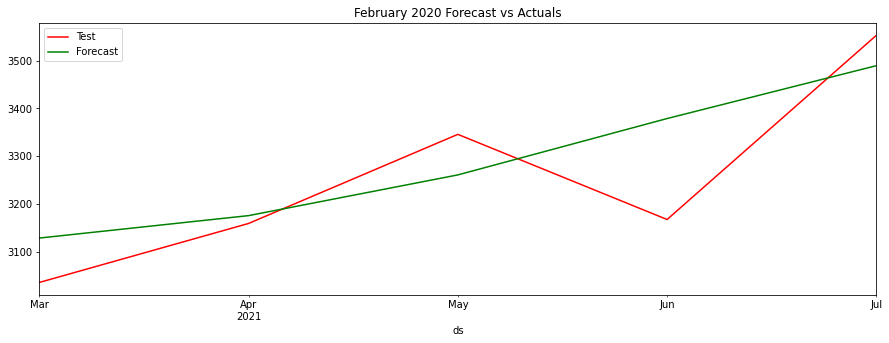

In [41]:
X_tst_forecast = model.predict(X_tst)

f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
X_tst.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
X_tst_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('February 2020 Forecast vs Actuals')
plt.show()

MSE

In [42]:
from sklearn.metrics import mean_squared_error


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_squared_error(X_tst['y'],X_tst_forecast['yhat'])


12970.003919002967

MAPE

In [34]:
mape = mean_absolute_percentage_error(X_tst['y'],X_tst_forecast['yhat'])
print("MAPE",round(mape,4))

MAPE 2.9164


Next 30 Days Prediction

In [ ]:
df

In [48]:
#make_future_dataframe(m, periods, freq = "day", include_history = TRUE)

future = m.make_future_dataframe(freq = "M",periods=6)
forecast_30 = m.predict(future)
forecast_30

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-07-31,1100.802905,1001.657189,1274.097301,1100.802905,1100.802905,40.038119,40.038119,40.038119,40.038119,40.038119,40.038119,0.0,0.0,0.0,1140.841025
1,2016-08-31,1117.746695,1009.973561,1274.353564,1117.746695,1117.746695,30.397131,30.397131,30.397131,30.397131,30.397131,30.397131,0.0,0.0,0.0,1148.143825
2,2016-09-30,1134.143910,1031.821656,1306.052345,1134.143910,1134.143910,32.872216,32.872216,32.872216,32.872216,32.872216,32.872216,0.0,0.0,0.0,1167.016126
3,2016-10-31,1151.087700,985.983285,1253.922131,1151.087700,1151.087700,-32.022472,-32.022472,-32.022472,-32.022472,-32.022472,-32.022472,0.0,0.0,0.0,1119.065228
4,2016-11-30,1167.484915,1015.414546,1284.892246,1167.484915,1167.484915,-8.792054,-8.792054,-8.792054,-8.792054,-8.792054,-8.792054,0.0,0.0,0.0,1158.692861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,2021-04-30,3197.715980,3032.543516,3304.165459,3187.610157,3206.158649,-22.148082,-22.148082,-22.148082,-22.148082,-22.148082,-22.148082,0.0,0.0,0.0,3175.567898
58,2021-05-31,3282.514368,3122.010751,3392.403656,3261.208005,3301.563416,-21.680833,-21.680833,-21.680833,-21.680833,-21.680833,-21.680833,0.0,0.0,0.0,3260.833535
59,2021-06-30,3364.577325,3236.237752,3515.195259,3327.233399,3395.096015,14.282471,14.282471,14.282471,14.282471,14.282471,14.282471,0.0,0.0,0.0,3378.859796
60,2021-07-31,3449.375713,3339.182041,3635.101580,3395.915368,3493.167152,40.160245,40.160245,40.160245,40.160245,40.160245,40.160245,0.0,0.0,0.0,3489.535958


In [52]:
future = m.make_future_dataframe(freq = "B",periods=140)
forecast_30 = m.predict(future)
forecast_30

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-07-31,1100.802905,1000.031341,1275.645828,1100.802905,1100.802905,40.038119,40.038119,40.038119,40.038119,40.038119,40.038119,0.0,0.0,0.0,1140.841025
1,2016-08-31,1117.746695,1005.219487,1282.491747,1117.746695,1117.746695,30.397131,30.397131,30.397131,30.397131,30.397131,30.397131,0.0,0.0,0.0,1148.143825
2,2016-09-30,1134.143910,1025.907853,1301.857816,1134.143910,1134.143910,32.872216,32.872216,32.872216,32.872216,32.872216,32.872216,0.0,0.0,0.0,1167.016126
3,2016-10-31,1151.087700,987.484045,1258.026953,1151.087700,1151.087700,-32.022472,-32.022472,-32.022472,-32.022472,-32.022472,-32.022472,0.0,0.0,0.0,1119.065228
4,2016-11-30,1167.484915,1021.659489,1302.788387,1167.484915,1167.484915,-8.792054,-8.792054,-8.792054,-8.792054,-8.792054,-8.792054,0.0,0.0,0.0,1158.692861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,2021-09-06,3550.586692,3421.807393,3741.903490,3481.947708,3616.341669,33.230171,33.230171,33.230171,33.230171,33.230171,33.230171,0.0,0.0,0.0,3583.816863
192,2021-09-07,3553.322124,3425.380718,3742.384873,3484.305838,3619.838520,33.002598,33.002598,33.002598,33.002598,33.002598,33.002598,0.0,0.0,0.0,3586.324722
193,2021-09-08,3556.057556,3431.530617,3750.021722,3486.678662,3623.030655,32.580518,32.580518,32.580518,32.580518,32.580518,32.580518,0.0,0.0,0.0,3588.638073
194,2021-09-09,3558.792988,3434.456840,3754.361431,3489.015126,3625.841772,31.986361,31.986361,31.986361,31.986361,31.986361,31.986361,0.0,0.0,0.0,3590.779349


In [54]:
forecast_30.to_csv("prophet_monthly.csv")

In [55]:
pwd

'/content'

In [22]:
import logging, sys
logging.disable(sys.maxsize)

changepoint_prior_scale=[0.1,0.2,0.3,0.4,0.5]
seasonality_prior_scale=[0.01,0.1, 2,3,4,5, 10]
seasonality_mode=['multiplicative','additive']
changepoint_range=[0.8,0.85,0.90, 0.95]

for i in changepoint_prior_scale:
  for j in seasonality_prior_scale:
    for k in seasonality_mode:
      for l in changepoint_range:
        model =Prophet(changepoint_prior_scale= i, seasonality_prior_scale=j, seasonality_mode=k, changepoint_range=l) 

        model.fit(X_tr)
        future = model.make_future_dataframe(periods=5, freq='M')
        forecast = model.predict(future)
        X_tst_forecast = model.predict(X_tst)
        from sklearn.metrics import mean_squared_error


        def mean_absolute_percentage_error(y_true, y_pred): 
          y_true, y_pred = np.array(y_true), np.array(y_pred)
          return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        print(i, j ,k ,l,mean_squared_error(X_tst['y'],X_tst_forecast['yhat']),mean_absolute_percentage_error(X_tst['y'],X_tst_forecast['yhat']))

0.1 0.01 multiplicative 0.8 42232.419872598286 4.983329069994735
0.1 0.01 multiplicative 0.85 160355.9814633825 11.769830130751476
0.1 0.01 multiplicative 0.9 126310.66443506248 10.46202941370681
0.1 0.01 multiplicative 0.95 164020.62661459122 11.90493343093493
0.1 0.01 additive 0.8 12970.003919002967 2.9164090438272194
0.1 0.01 additive 0.85 126901.54008482528 10.431250822890274
0.1 0.01 additive 0.9 94691.3134962477 8.912099391815273
0.1 0.01 additive 0.95 132873.21937191475 10.686881881814925
0.1 0.1 multiplicative 0.8 49821.208930590634 5.623980151573641
0.1 0.1 multiplicative 0.85 284158.7024494678 15.742084407584784
0.1 0.1 multiplicative 0.9 284352.13319942506 15.688355768932874
0.1 0.1 multiplicative 0.95 300898.4180922804 16.211412827275286
0.1 0.1 additive 0.8 13035.107686693696 2.8083134911173357
0.1 0.1 additive 0.85 166455.0287909985 11.984253932696882
0.1 0.1 additive 0.9 108376.949074773 9.553263743893515
0.1 0.1 additive 0.95 172662.98941541417 12.230569165241851
0.1 2 

In [51]:
import logging, sys
logging.disable(sys.maxsize)

changepoint_prior_scale=[0.1,0.2,0.3,0.4,0.5]
seasonality_mode=['multiplicative','additive']
changepoint_range=[0.8,0.85,0.90, 0.95]

for i in changepoint_prior_scale:
    for k in seasonality_mode:
      for l in changepoint_range:
        model =Prophet(changepoint_prior_scale= i, seasonality_prior_scale=j, seasonality_mode=k, changepoint_range=l) 

        model.fit(X_tr)
        future = model.make_future_dataframe(periods=5, freq='M')
        forecast = model.predict(future)
        X_tst_forecast = model.predict(X_tst)
        from sklearn.metrics import mean_squared_error


        def mean_absolute_percentage_error(y_true, y_pred): 
          y_true, y_pred = np.array(y_true), np.array(y_pred)
          return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        print(i, k ,l,mean_squared_error(X_tst['y'],X_tst_forecast['yhat']),mean_absolute_percentage_error(X_tst['y'],X_tst_forecast['yhat']))

0.1 multiplicative 0.8 42232.419872598286 4.983329069994735
0.1 multiplicative 0.85 160355.9814633825 11.769830130751476
0.1 multiplicative 0.9 126310.66443506248 10.46202941370681
0.1 multiplicative 0.95 164020.62661459122 11.90493343093493
0.1 additive 0.8 12970.003919002967 2.9164090438272194
0.1 additive 0.85 126901.54008482528 10.431250822890274
0.1 additive 0.9 94691.3134962477 8.912099391815273
0.1 additive 0.95 132873.21937191475 10.686881881814925
0.2 multiplicative 0.8 41244.72294309682 5.244898448649737
0.2 multiplicative 0.85 205631.38204290965 13.528272494107457
0.2 multiplicative 0.9 191211.7899644696 13.05006958798376
0.2 multiplicative 0.95 217227.47960955967 13.907455077732486
0.2 additive 0.8 37219.30011939551 5.008102902323704
0.2 additive 0.85 162602.76787839094 11.946848967991267
0.2 additive 0.9 146746.49636186854 11.345348103873809
0.2 additive 0.95 174479.3404978931 12.392547145208315
0.3 multiplicative 0.8 55235.77752216785 6.383231771543667
0.3 multiplicative 